In [329]:
import tensorflow as tf
tf.enable_eager_execution()
%load_ext tensorboard

from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy
from glob import glob
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
keras = tf.keras



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
#just declaring some UTILS functions
IMG_SIZE = 224
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label


In [331]:
#load dataset in splitted sizes
raw_train,metadata = tfds.load("stanford_dogs", split="train[:80%]",with_info=True,as_supervised=True)
raw_validation,metadata = tfds.load("stanford_dogs", split="train[81%:90]",with_info=True,as_supervised=True)
raw_test,metadata = tfds.load("stanford_dogs", split="test[91%:]",with_info=True,as_supervised=True)
print(raw_train)


<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>


In [0]:
#resize all images to 224
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)


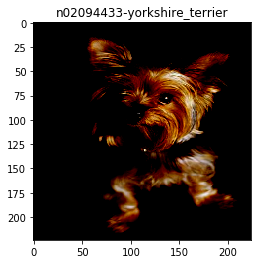

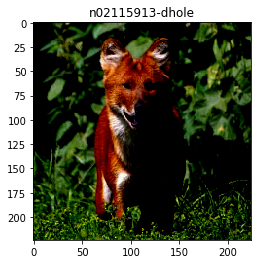

In [333]:
#check that the dataset has been loaded correctly
get_label_name = metadata.features['label'].int2str
for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


In [0]:
#shuffle and batch the data
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 1000  

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)



In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Xception base model from github
#base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,include_top=False)

In [336]:
for image_batch, label_batch in train_batches.take(1):
  pass 
image_batch.shape
#feature_batch = base_model(image_batch)

TensorShape([Dimension(20), Dimension(224), Dimension(224), Dimension(3)])

In [0]:
#base_model.trainable = False


In [0]:
#declare global average layer pooling
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)

In [0]:
# declare prediction layer on top
#prediction_layer = keras.layers.Dense(120,activation="softmax")
#prediction_batch = prediction_layer(feature_batch_average)

In [339]:
# compile base model with global average pooling and prediction layer
#model = tf.keras.Sequential([base_model,global_average_layer,prediction_layer])
from tensorflow.keras import regularizers
model = tf.keras.Sequential()
model.add(keras.layers.BatchNormalization(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=64, kernel_size=3,kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=128, kernel_size=3,kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=256, kernel_size=3,kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=512, kernel_size=3,kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.GlobalAveragePooling2D())




model.add(keras.layers.Flatten())
#start of connected layers
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())

#model.add(keras.layers.Dense(2048, activation='relu'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(120, activation='softmax'))

model.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_146 (Bat (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 111, 111, 32)      0         
_________________________________________________________________
batch_normalization_147 (Bat (None, 111, 111, 32)      128       
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 54, 54, 64)      

In [0]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,decay_steps=300*1000,decay_rate=1,staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [0]:
#train the model
model.compile(optimizer=get_optimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [342]:
steps_per_epoch = 10
validation_steps = 20
loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))

print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 77ms/step - loss: 6.9094 - acc: 0.0075
initial loss: 6.91
initial accuracy: 0.01


In [343]:

!mkdir saved_models

mkdir: cannot create directory ‘saved_models’: File exists


In [0]:
import datetime

initial_epochs = 20

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

callbacks_list = [checkpointer,es_callback]

history = model.fit(train_batches,
                    steps_per_epoch=300,
                    epochs=initial_epochs,
                    callbacks=callbacks_list,
                    validation_data=validation_batches)


Train for 300 steps
Epoch 1/20
299/300 [============================>.] - ETA: 0s - loss: 7.7304 - acc: 0.0189
Epoch 00001: val_loss improved from inf to 8.39548, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
300/300 [==============================] - 45s 148ms/step - loss: 7.7306 - acc: 0.0192 - val_loss: 8.3955 - val_acc: 0.0176
Epoch 2/20
53/54 [============================>.] - ETA: 0s - loss: 7.2650 - acc: 0.0189
Epoch 00002: val_loss improved from 8.39548 to 6.56051, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
300/54 [======================================================================================================================================================================] - 39s 131ms/step - loss: 7.2135 - acc: 0.0208 - val_loss: 6.5605 - val_acc: 0.0111
Epoch 3/20
53/54 [============================>.] - ETA: 0s - loss: 6.5702 - acc: 0.0264
Epoch 00003: val_loss improved from 6.56051 to 5.85217, saving model to saved_mode

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5');

In [0]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         steps_per_epoch=1000,
                         initial_epoch =  history.epoch[-1],
callbacks=callbacks_list,
                         validation_data=validation_batches)

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5');

In [0]:
fine_tune_epochs = 10
total_epochs =  total_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         steps_per_epoch=1000,
                         initial_epoch =  history.epoch[-1],
callbacks=callbacks_list,
                         validation_data=validation_batches)

In [0]:
model.save("testmodelx.model")

In [0]:
import cv2

def prepare(filepath):
    IMG_SIZE = 300  # 50 in txt-based
    img_array = cv2.imread(filepath,cv2.COLOR_BGR2RGB)  # read in the image, convert to grayscale
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image to match model's expected sizing
    return tf.cast(new_array.reshape(-1,IMG_SIZE, IMG_SIZE, 3),tf.float32)  # return the image with shaping that TF wants.

In [0]:
model = tf.keras.models.load_model("testmodelx.model")


In [0]:
import urllib.request
urllib.request.urlretrieve("https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/13001049/Basset-Hound-On-White-01.jpg", "dogtest.jpg")


In [0]:
image = prepare('dogtest.jpg')
prediction = model.predict(image)   
print(prediction[0])
plt.figure()
plt.imshow(cv2.imread('dogtest.jpg'))